In [73]:
import torch
import torchvision
import torch.nn as nn
from utils import compute_iou
from data.cbis_ddsm import CBIS_DDSM, get_loaders
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from collections import defaultdict
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import pandas as pd
import os
import matplotlib.pyplot as plt

In [8]:
# Check if gpu is available

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device', device)

CUDA_LAUNCH_BLOCKING=1

device name NVIDIA GeForce GTX 1080 Ti
device cuda


In [9]:
def print_metrics(metrics, epoch_samples):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("Metrics: {}".format(", ".join(outputs)))

In [10]:
def calc_metrics(outputs, target, metrics, bce_weight=0.5):
    # bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = torch.sigmoid(outputs)
    # dice = dice_loss(pred, target)

    # loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    # metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    
    

    # return loss

In [33]:
def test_model(model, testloader):
    
    model.eval()
    
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        
        for i, batch in enumerate(tqdm(testloader)):

            inputs, target = batch['image'], batch['target']
            y_true.extend(target.numpy())
            # mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
            inputs = inputs.to(device)
            target = target.to(device)
            
            outputs = model(inputs)
            
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            y_pred.extend(predicted.cpu().numpy())
    auc = roc_auc_score(y_true, y_pred)
    test_acc = 100 * correct // total
    print(f'Test Acc: {100 * correct // total} % \t AUC: {auc}')
    return test_acc, auc

In [83]:
### Parameters

num_epochs = 30
lr = 1e-5

num_class = 2 #binary problem  
# model = ResNetUNet(num_class).to(device)
model = torchvision.models.resnet18(pretrained=True)

# Freeze model weights
# for param in model.parameters():
#     param.requires_grad = False

num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, num_class)
model = model.to(device)

criterion = nn.CrossEntropyLoss()


# freeze backbone layers
# for l in model.base_layers:
#     for param in l.parameters():
#         param.requires_grad = False
        
        
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

#dataloader parameters

args={
    'data_path': "/datasets/mamografia/CBIS-DDSM_organized/images/preprocessed",
    "batch_size": 64,
    "size1": 270,
    "size": 256
}

# save_log_file = "classification_bs{}_size{}_ep{}_lr{}_log.csv".format(args["batch_size"], args["size"],num_epochs, lr)
save_log_path = "output/classification/bs{}_size{}_ep{}_lr{}/".format(args["batch_size"], args["size"],num_epochs, lr)
os.makedirs(save_log_path, exist_ok=True)

train_loader, test_loader = get_loaders(args)

In [84]:


## Training Loop
best_loss = 1e10
log_dict = {'acc_train':[],
           'acc_test':[],
            'auc_test':[],
            # 'loss_train':[],
            'epoch':[]
           }
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    since = time.time()
    model.train()
    
    metrics = defaultdict(float)
    epoch_samples = 0
    total = 0
    correct = 0

    print(f"Epoch {epoch} - Training...\n")
    # for inputs, labels in dataloaders[phase]:
    for i, batch in enumerate(tqdm(train_loader)):
        
        inputs, target = batch['image'], batch['target']
        
        # mask = mask.mean(1,keepdim=True)  #transform from [batch_size, 3, size, size] to [batch,size, 1, size, size]
        
        inputs = inputs.to(device)
        target = target.to(device)
        # mask = mask.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        # with torch.set_grad_enabled(phase == 'train'):
        outputs = model(inputs)
        
        # loss = calc_loss(outputs, mask, metrics, bce_weight=1)
        
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()

        # statistics
        epoch_samples += inputs.size(0)
        
        # print statistics
        running_loss = loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
        # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss:.3f}')
        # running_loss = 0.0

    scheduler.step()
    print(f'Train Acc: {100 * correct // total} %')
    
    #test
    print("Testing...")
    test_acc, auc = test_model(model, test_loader)
    
    log_dict['epoch'].append(epoch)
    log_dict['acc_train'].append(100 * correct // total)
    # log_dict['loss_train'] = 
    log_dict['acc_test'].append(test_acc)
    log_dict['auc_test'].append(auc)

    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# torch.save(model.state_dict(), "trained_model.pth")

training_df = pd.DataFrame.from_dict(data=log_dict)
training_df.to_csv(os.path.join(save_log_path, 'train_log.csv'),index="False")



Epoch 0/29
----------
Epoch 0 - Training...



100%|██████████| 20/20 [14:04<00:00, 42.22s/it]  


Train Acc: 54 %
Testing...


100%|██████████| 6/6 [03:32<00:00, 35.45s/it] 


Test Acc: 53 % 	 AUC: 0.5076185282607302
17m 38s
Epoch 1/29
----------
Epoch 1 - Training...



100%|██████████| 20/20 [12:07<00:00, 36.37s/it]


Train Acc: 56 %
Testing...


100%|██████████| 6/6 [04:20<00:00, 43.47s/it] 


Test Acc: 54 % 	 AUC: 0.5000641560274588
16m 30s
Epoch 2/29
----------
Epoch 2 - Training...



100%|██████████| 20/20 [11:42<00:00, 35.10s/it]


Train Acc: 61 %
Testing...


100%|██████████| 6/6 [04:49<00:00, 48.22s/it] 


Test Acc: 57 % 	 AUC: 0.5542759992301276
16m 33s
Epoch 3/29
----------
Epoch 3 - Training...



100%|██████████| 20/20 [13:55<00:00, 41.78s/it]


Train Acc: 62 %
Testing...


100%|██████████| 6/6 [05:24<00:00, 54.13s/it] 


Test Acc: 61 % 	 AUC: 0.6005966510553666
19m 21s
Epoch 4/29
----------
Epoch 4 - Training...



100%|██████████| 20/20 [13:18<00:00, 39.94s/it]


Train Acc: 63 %
Testing...


100%|██████████| 6/6 [05:06<00:00, 51.02s/it] 


Test Acc: 63 % 	 AUC: 0.6118399948675178
18m 26s
Epoch 5/29
----------
Epoch 5 - Training...



100%|██████████| 20/20 [13:36<00:00, 40.82s/it]


Train Acc: 66 %
Testing...


100%|██████████| 6/6 [04:46<00:00, 47.81s/it] 


Test Acc: 63 % 	 AUC: 0.6155610444601269
18m 25s
Epoch 6/29
----------
Epoch 6 - Training...



100%|██████████| 20/20 [12:53<00:00, 38.67s/it]


Train Acc: 67 %
Testing...


100%|██████████| 6/6 [05:29<00:00, 54.90s/it] 


Test Acc: 63 % 	 AUC: 0.6202604734714827
18m 24s
Epoch 7/29
----------
Epoch 7 - Training...



100%|██████████| 20/20 [11:24<00:00, 34.24s/it]


Train Acc: 67 %
Testing...


100%|██████████| 6/6 [03:42<00:00, 37.06s/it] 


Test Acc: 62 % 	 AUC: 0.6350323987938667
15m 8s
Epoch 8/29
----------
Epoch 8 - Training...



100%|██████████| 20/20 [11:01<00:00, 33.10s/it]


Train Acc: 69 %
Testing...


100%|██████████| 6/6 [04:23<00:00, 44.00s/it] 


Test Acc: 63 % 	 AUC: 0.6348078526977609
15m 28s
Epoch 9/29
----------
Epoch 9 - Training...



100%|██████████| 20/20 [11:58<00:00, 35.94s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [04:23<00:00, 43.94s/it] 


Test Acc: 63 % 	 AUC: 0.6368768845833066
16m 23s
Epoch 10/29
----------
Epoch 10 - Training...



100%|██████████| 20/20 [10:46<00:00, 32.35s/it]


Train Acc: 69 %
Testing...


100%|██████████| 6/6 [04:21<00:00, 43.50s/it] 


Test Acc: 63 % 	 AUC: 0.6310868031051518
15m 9s
Epoch 11/29
----------
Epoch 11 - Training...



100%|██████████| 20/20 [10:51<00:00, 32.55s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [04:16<00:00, 42.77s/it] 


Test Acc: 63 % 	 AUC: 0.634695579649708
15m 9s
Epoch 12/29
----------
Epoch 12 - Training...



100%|██████████| 20/20 [10:49<00:00, 32.48s/it]


Train Acc: 69 %
Testing...


100%|██████████| 6/6 [04:18<00:00, 43.00s/it] 


Test Acc: 63 % 	 AUC: 0.6299961506383526
15m 8s
Epoch 13/29
----------
Epoch 13 - Training...



100%|██████████| 20/20 [11:09<00:00, 33.46s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:10<00:00, 41.76s/it] 


Test Acc: 62 % 	 AUC: 0.6169885160710848
15m 21s
Epoch 14/29
----------
Epoch 14 - Training...



100%|██████████| 20/20 [11:28<00:00, 34.42s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [03:28<00:00, 34.71s/it] 


Test Acc: 63 % 	 AUC: 0.6322897286200038
14m 57s
Epoch 15/29
----------
Epoch 15 - Training...



100%|██████████| 20/20 [11:28<00:00, 34.43s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [03:40<00:00, 36.68s/it]


Test Acc: 63 % 	 AUC: 0.6275902996086482
15m 9s
Epoch 16/29
----------
Epoch 16 - Training...



100%|██████████| 20/20 [10:59<00:00, 32.99s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:03<00:00, 40.62s/it] 


Test Acc: 63 % 	 AUC: 0.6345833066016553
15m 5s
Epoch 17/29
----------
Epoch 17 - Training...



100%|██████████| 20/20 [10:57<00:00, 32.89s/it]


Train Acc: 69 %
Testing...


100%|██████████| 6/6 [04:20<00:00, 43.36s/it] 


Test Acc: 63 % 	 AUC: 0.625184448578944
15m 19s
Epoch 18/29
----------
Epoch 18 - Training...



100%|██████████| 20/20 [11:27<00:00, 34.36s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [04:55<00:00, 49.17s/it] 


Test Acc: 63 % 	 AUC: 0.6333803810868031
16m 23s
Epoch 19/29
----------
Epoch 19 - Training...



100%|██████████| 20/20 [11:11<00:00, 33.59s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:25<00:00, 44.26s/it] 


Test Acc: 63 % 	 AUC: 0.6299961506383526
15m 38s
Epoch 20/29
----------
Epoch 20 - Training...



100%|██████████| 20/20 [11:19<00:00, 34.00s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:02<00:00, 40.47s/it] 


Test Acc: 62 % 	 AUC: 0.6252967216269968
15m 24s
Epoch 21/29
----------
Epoch 21 - Training...



100%|██████████| 20/20 [11:08<00:00, 33.44s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [02:34<00:00, 25.72s/it]


Test Acc: 63 % 	 AUC: 0.6287932251235003
13m 44s
Epoch 22/29
----------
Epoch 22 - Training...



100%|██████████| 20/20 [11:06<00:00, 33.34s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [04:11<00:00, 41.99s/it] 


Test Acc: 63 % 	 AUC: 0.633492654134856
15m 20s
Epoch 23/29
----------
Epoch 23 - Training...



100%|██████████| 20/20 [11:05<00:00, 33.25s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:24<00:00, 44.03s/it] 


Test Acc: 63 % 	 AUC: 0.6321774555719509
15m 31s
Epoch 24/29
----------
Epoch 24 - Training...



100%|██████████| 20/20 [11:04<00:00, 33.25s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:26<00:00, 44.49s/it] 


Test Acc: 63 % 	 AUC: 0.6286809520754474
15m 33s
Epoch 25/29
----------
Epoch 25 - Training...



100%|██████████| 20/20 [11:04<00:00, 33.24s/it]


Train Acc: 69 %
Testing...


100%|██████████| 6/6 [04:30<00:00, 45.04s/it] 


Test Acc: 62 % 	 AUC: 0.6228908705972926
15m 36s
Epoch 26/29
----------
Epoch 26 - Training...



100%|██████████| 20/20 [10:34<00:00, 31.71s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [03:36<00:00, 36.10s/it] 


Test Acc: 63 % 	 AUC: 0.6263873740937961
14m 11s
Epoch 27/29
----------
Epoch 27 - Training...



100%|██████████| 20/20 [10:24<00:00, 31.22s/it]


Train Acc: 71 %
Testing...


100%|██████████| 6/6 [04:26<00:00, 44.41s/it] 


Test Acc: 63 % 	 AUC: 0.6311990761532045
14m 51s
Epoch 28/29
----------
Epoch 28 - Training...



100%|██████████| 20/20 [12:03<00:00, 36.17s/it]


Train Acc: 70 %
Testing...


100%|██████████| 6/6 [04:09<00:00, 41.59s/it] 


Test Acc: 63 % 	 AUC: 0.640485661127863
16m 13s
Epoch 29/29
----------
Epoch 29 - Training...



100%|██████████| 20/20 [11:51<00:00, 35.59s/it]


Train Acc: 69 %
Testing...


100%|██████████| 6/6 [04:15<00:00, 42.62s/it] 


Test Acc: 63 % 	 AUC: 0.6287932251235003
16m 8s


In [64]:
import numpy as np
a = np.array([3,4])

In [20]:
b = []
b.extend(a)

In [21]:
b

[3, 4]

In [22]:
c = np.array([13,41])
b.extend(c)
print(b)

[3, 4, 13, 41]


# Training log

In [85]:
df = pd.read_csv("output/classification/bs64_size256_ep30_lr1e-05/train_log.csv")


In [86]:
df.head(10)

,Unnamed: 0,acc_train,acc_test,auc_test,epoch
0,0,54,53,0.507619,0
1,1,56,54,0.500064,1
2,2,61,57,0.554276,2
3,3,62,61,0.600597,3
4,4,63,63,0.611840,4
5,5,66,63,0.615561,5
6,6,67,63,0.620260,6
7,7,67,62,0.635032,7
8,8,69,63,0.634808,8
9,9,71,63,0.636877,9


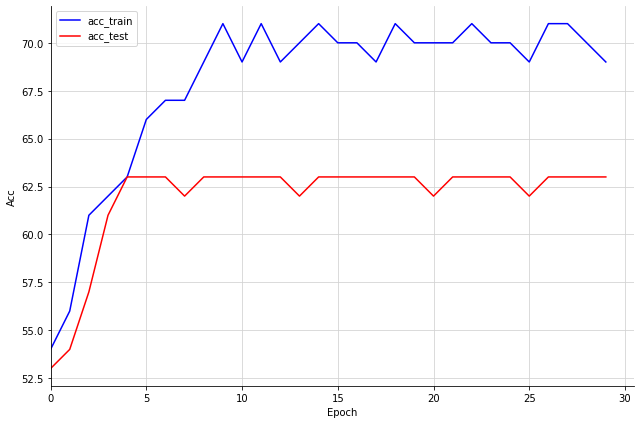

In [87]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

line1 = ax.plot(df['epoch'], df['acc_train'], color="blue", label="acc_train")
line2 = ax.plot(df['epoch'], df['acc_test'], color="red", label="acc_test")
# line2 = ax.plot(x, y_val, color="red", label="val")

# Nicer visuals.
# ax.set_title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="both", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("Epoch")
ax.set_ylabel("Acc")
# ax.xaxis.set_ticks(np.arange(xtick_range[0], xtick_range[1], xtick_range[2]))
# ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(left=0)
# ax.yaxis.set_ticks(np.arange(ytick_range[0], ytick_range[1], ytick_range[2]))
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.patch.set_alpha(0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best")

# Save graph
save_path = True
plt.tight_layout()
if save_path:
    # plt.savefig(fname=save_path, dpi=300)
    plt.savefig(fname=os.path.join(save_log_path, 'acc.png'), dpi=300)
    


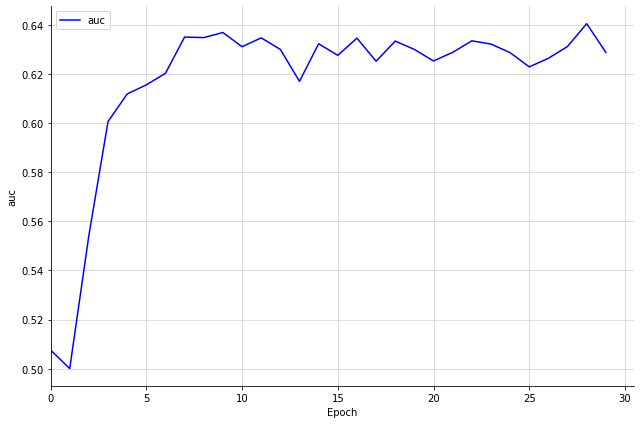

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

line1 = ax.plot(df['epoch'], df['auc_test'], color="blue", label="auc")
# line2 = ax.plot(df['epoch'], df['acc_test'], color="red", label="acc_test")
# line2 = ax.plot(x, y_val, color="red", label="val")

# Nicer visuals.
# ax.set_title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=True, which="major", axis="both", color="#d3d3d3", linestyle="-")
ax.grid(b=True, which="minor", axis="both", color="#e7e7e7", linestyle="dashed")
ax.set_xlabel("Epoch")
ax.set_ylabel("auc")
# ax.xaxis.set_ticks(np.arange(xtick_range[0], xtick_range[1], xtick_range[2]))
# ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_xlim(left=0)
# ax.yaxis.set_ticks(np.arange(ytick_range[0], ytick_range[1], ytick_range[2]))
# ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.patch.set_alpha(0)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels, loc="best")

# Save graph
save_path = True
plt.tight_layout()
if save_path:
    # plt.savefig(fname=save_path, dpi=300)
    plt.savefig(fname=os.path.join(save_log_path, 'loss.png'), dpi=300)


## CAM

In [1]:
# Define your model
from torchvision.models import resnet18
model = resnet18(pretrained=True).eval()



In [4]:
# Set your CAM extractor
from torchcam.torchcam.methods import SmoothGradCAMpp
cam_extractor = SmoothGradCAMpp(model)

ImportError: cannot import name 'methods'